## Dilution with Global Mechanisms
Global mechanisms provide a framework to have certain reactions work on all, or almost all, species in a CRN. They are to be used with caution: depending on the order global mechanisms are applied, different resulting CRNs are possible. In fact, the recommendation is to only use global mechanisms for degredation by dilution. In the following example, a model will be set up where global mechanisms cause degredation by dilution on all species which are not labeled as "genomic" or "machinery".

Under the hood, global mechanisms work just like normal mechanisms - they take a set of species and compile them into CRNs. Global mechanisms are called at the end of the compilation, so they apply to all species generated by all local mechanisms. In order to make global mechanisms more selective, a filter_dict keywork can be used. The filter_dict (str:True/False) takes some str such as "dna" or "genomic" which is either a specie type, name, or attribute. The mechanism is then applied or not based upon the value of that attribute in the filter_dict. For exampe filter_dict = {"dna":False} would not apply its mechanism to any "dna" species. For species with no attributes in the filter_dict, a global mechanism defaults to its default_on keyword, which can be True or False.

In the below example, we will show how filters and attributes work on constuitively expressed genes using dilution as the prototypical example. 

Species (15) = {0. protein[RNAP(machinery)], 1. protein[Ribo(machinery)], 2. protein[RNAase(machinery)], 3. complex[protein[Ribo]:rna[G1](machinery)], 4. complex[protein[RNAase]:rna[G1](machinery)], 5. complex[dna[G1]:protein[RNAP](machinery)], 6. rna[G1], 7. dna[G1], 8. protein[G1], 9. complex[protein[RNAase]:rna[G2](machinery)], 10. complex[dna[G2]:protein[RNAP](machinery, genomic)], 11. complex[protein[Ribo]:rna[G2](machinery)], 12. dna[G2(genomic)], 13. protein[G2], 14. rna[G2]}
Reactions (17) = [
0. dna[G1] + protein[RNAP(machinery)] <--> complex[dna[G1]:protein[RNAP](machinery)]        
        massaction: k_f(dna[G1],protein[RNAP(machinery)])=100*dna[G1]*protein[RNAP(machinery)]
        k_r(complex[dna[G1]:protein[RNAP](machinery)])=20*complex[dna[G1]:protein[RNAP](machinery)]
1. complex[dna[G1]:protein[RNAP](machinery)] --> dna[G1] + rna[G1] + protein[RNAP(machinery)]        
        massaction: k_f(complex[dna[G1]:protein[RNAP](machinery)])=3*complex[dna[G1]:protein[RNAP](mach

C:\ProgramData\Anaconda3\lib\site-packages\html5lib\_trie\_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


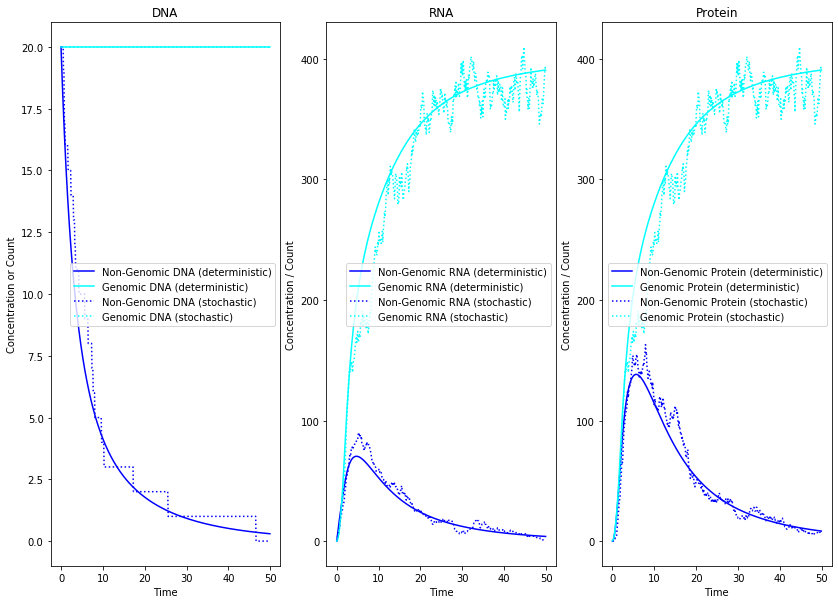

In [1]:
from biocrnpyler import *

#We will only use default parameters in this model, for simplicity.
kb, ku, ktx, ktl, kdeg, kdil = 100, 20, 3, 2, .5, .5
parameters = {"kb":kb, "ku":ku, "ktx":ktx, "ktl":ktl, "kdeg": kdeg, "kdil":kdil}

#Creates a global dilution mechanism that acts on all species generated except for
# those with the type or attribute "genome" or "machinery"
dilution_mechanism = Dilution(filter_dict = {"genomic":False, "machinery":False}, default_on = True)

#Add this mechanism to a dictionary which is passed into the Mixture txtl.TxTlExtract
global_mechanisms = {"dilution":dilution_mechanism}
myMixture = TxTlExtract(name = "txtl", parameters = parameters, global_mechanisms = global_mechanisms, parameter_warnings= False)

#Add machinery attributes to species I want constiutively expressed at the dilution rate
myMixture.rnap.add_attribute("machinery")
myMixture.rnaase.add_attribute("machinery")
myMixture.ribosome.add_attribute("machinery")

#Creates a dna assembly. This assembly is type "dna" so it will be degraded
A_dna = DNAassembly(name = "G1", promoter = "pBest", rbs = "BCD2")

#Create another dna assembly but set its internal specie's attributes to contain "genomic" so it will not be degraded
#Note: this only protects the dna_G2 species encoded by this assembly as well as complex species (eg rnap:DNA) which inherit their subspecies attributes.
A_genome = DNAassembly(name = "G2", promoter = "pBest", rbs = "BCD2", attributes = ["genomic"])


myMixture.add_components(A_dna)
myMixture.add_components(A_genome)
myCRN = myMixture.compile_crn()
print(myCRN.pretty_print(show_rates = True, show_materials = True, show_attributes = True))


print("Simulating with BioSCRAPE")
import numpy as np
import pylab as plt
timepoints = np.arange(0, 50, .1)

x0_dict = {repr(myMixture.ribosome.get_species()):100,
           repr(myMixture.rnap.get_species()):20,
           repr(myMixture.rnaase.get_species()):10,
           repr(A_dna.dna):20,
           repr(A_genome.dna):20}

full_result_sto = myCRN.simulate_with_bioscrape(timepoints, x0_dict, stochastic = True)
full_result_det = myCRN.simulate_with_bioscrape(timepoints, x0_dict, stochastic = False)

if full_result_det and full_result_sto:
    #chemical_reaction_network.get_all_species_containing is a useful shortcut to get lists of species
    tot_A_dna_det = np.sum(full_result_det[myCRN.get_all_species_containing(A_dna.dna, return_as_strings=True)], 1)
    tot_A_genome_det = np.sum(full_result_det[myCRN.get_all_species_containing(A_genome.dna, return_as_strings=True)], 1)
    tot_A_dna_sto = np.sum(full_result_sto[myCRN.get_all_species_containing(A_dna.dna, return_as_strings=True)], 1)
    tot_A_genome_sto = np.sum(full_result_sto[myCRN.get_all_species_containing(A_genome.dna, return_as_strings=True)], 1)

    tot_A_dna_rna_det = np.sum(full_result_det[myCRN.get_all_species_containing(A_dna.transcript, return_as_strings=True)], 1)
    tot_A_genome_rna_det = np.sum(full_result_det[myCRN.get_all_species_containing(A_genome.protein, return_as_strings=True)], 1)
    tot_A_dna__rna_sto = np.sum(full_result_sto[myCRN.get_all_species_containing(A_dna.transcript, return_as_strings=True)], 1)
    tot_A_genome_rna_sto = np.sum(full_result_sto[myCRN.get_all_species_containing(A_genome.protein, return_as_strings=True)], 1)


    plt.figure(figsize = (14, 10))
    plt.subplot(131)
    plt.plot(timepoints, tot_A_dna_det, color = "blue", label = "Non-Genomic DNA (deterministic)")
    plt.plot(timepoints, tot_A_genome_det, color = "cyan", label = "Genomic DNA (deterministic)")
    plt.plot(timepoints, tot_A_dna_sto, ":", color = "blue", label = "Non-Genomic DNA (stochastic)")
    plt.plot(timepoints, tot_A_genome_sto, ":", color = "cyan", label = "Genomic DNA (stochastic)")
    plt.legend()
    plt.xlabel("Time")
    plt.title("DNA")
    plt.ylabel("Concentration or Count")

    plt.subplot(132)
    plt.plot(timepoints, tot_A_dna_rna_det, color = "blue", label = "Non-Genomic RNA (deterministic)")
    plt.plot(timepoints, tot_A_genome_rna_det, color = "cyan", label = "Genomic RNA (deterministic)")
    plt.plot(timepoints, tot_A_dna__rna_sto, ":", color = "blue", label = "Non-Genomic RNA (stochastic)")
    plt.plot(timepoints, tot_A_genome_rna_sto, ":", color = "cyan", label = "Genomic RNA (stochastic)")
    plt.legend()
    plt.xlabel("Time")
    plt.title("RNA")
    plt.ylabel("Concentration / Count")

    plt.subplot(133)
    plt.plot(timepoints, full_result_det[str(A_dna.protein)], color = "blue", label = "Non-Genomic Protein (deterministic)")
    plt.plot(timepoints, full_result_det[str(A_genome.protein)], color = "cyan", label = "Genomic Protein (deterministic)")
    plt.plot(timepoints, full_result_sto[str(A_dna.protein)], ":", color = "blue", label = "Non-Genomic Protein (stochastic)")
    plt.plot(timepoints, full_result_sto[str(A_genome.protein)], ":", color = "cyan", label = "Genomic Protein (stochastic)")
    plt.legend()
    plt.title("Protein")
    plt.xlabel("Time")
    plt.ylabel("Concentration / Count")

    plt.show()
